# ECSE415 - Intro to Computer Vision
## Tutorial 5 - Image Stitching and Clustering

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Image Stitching

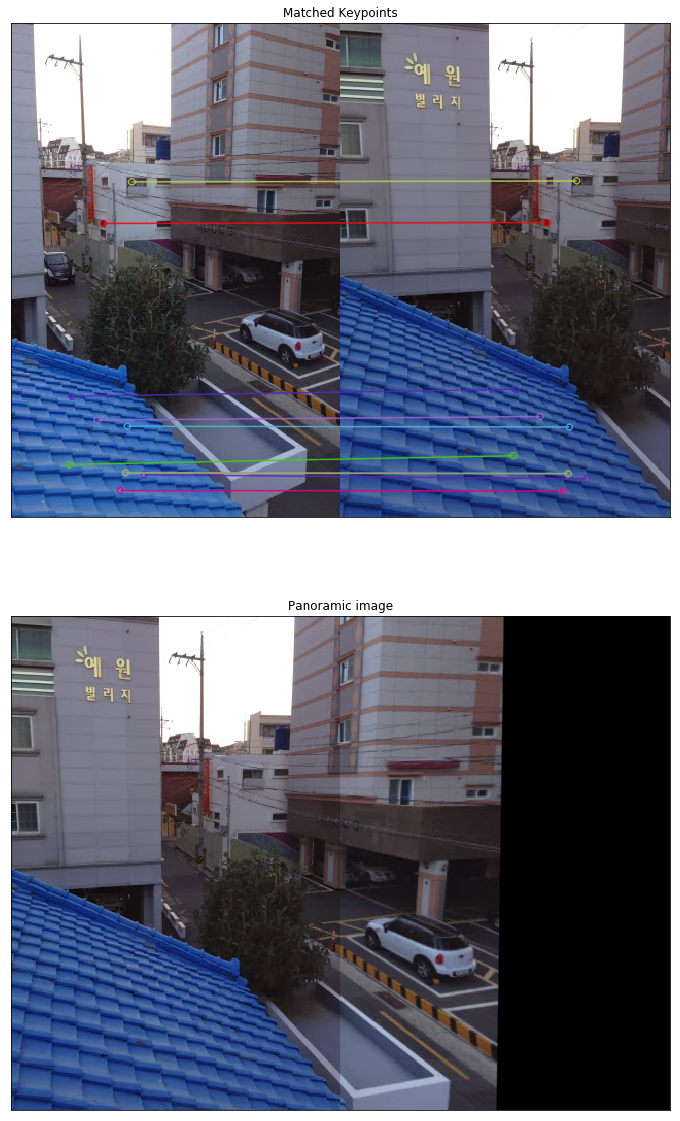

In [69]:
# Read images to stitch
imgl = cv2.imread('S1.jpg')
imgr = cv2.imread('S2.jpg')

imgl = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
imgr = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_l, descriptors_l = sift_obj.detectAndCompute(imgl, None)
keypoints_r, descriptors_r = sift_obj.detectAndCompute(imgr, None)

# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(descriptors_r,descriptors_l)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch = cv2.drawMatches(imgr,keypoints_r,imgl,keypoints_l, matches[:10], imgr, flags=2)

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints_r[i].pt for (__, i) in GoodMatches])
mpl = np.float32([keypoints_l[i].pt for (i, __) in GoodMatches])

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(imgr, H, (imgr.shape[1]+imgl.shape[1],imgr.shape[0]))
wimg[:,:imgl.shape[1],:] = imgl

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(imgmatch)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.subplot(212)
plt.imshow(wimg)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

## Feathering (Linear Blending)

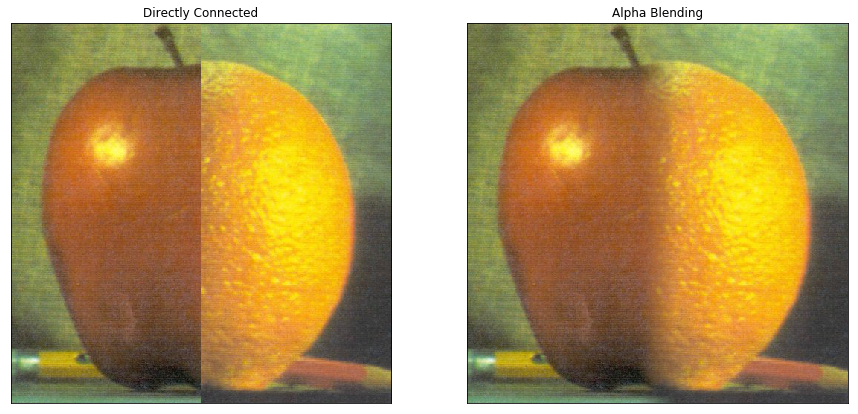

In [38]:
##################
# IMAGE BLENDING #
##################

# read images
A = cv2.imread('apple.jpg')
B = cv2.imread('orange.jpg')

# width and height of image
col, row = A.shape[0:2]
# image with direct connecting each half
real = np.hstack((A[:, :round(col/2)], B[:, round(col/2):]))

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(A.shape[1], ramp_size, round(A.shape[1]/2), 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * A + alpha.reshape(1,-1,1)*B
I_blend = np.uint8(I_blend)  # convert back to uint8

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(real, cv2.COLOR_RGB2BGR))
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(I_blend, cv2.COLOR_RGB2BGR))
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

## Pyramid Blending

(512, 512, 3)
(512, 512, 3)
3 3
(128, 128, 3) 3
(128, 128, 3) (128, 128, 3)
(128, 128, 1)
(128, 128, 1)
(256, 256, 3) (256, 256, 3)
(256, 256, 1)
(256, 256, 1)
(512, 512, 3) (512, 512, 3)
(512, 512, 1)
(512, 512, 1)


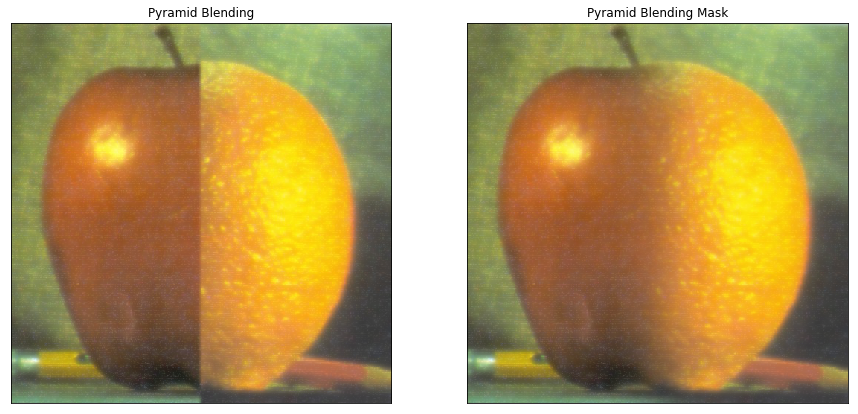

In [67]:
# parameters
g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size

""" PYRAMID BLENDING """
row, col, dpt = A.shape
# generate Gaussian pyramid for imgA
G = A.copy()

gp1 = [G]
print(gp1[0].shape)
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Gaussian pyramid for imgB
G = B.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
print(gp1[0].shape)
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
#     print(lp)
#     print('hello')
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
#     print(la.shape)
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((A.shape[1], A.shape[0]))
# create mask
mask[:, round(A.shape[1]/2):] = 1
# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)
# generate Gaussian pyramid
G = mask.copy()
GR = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)

# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
print(len(lp1), len(lp2))
print(lp1[0].shape, len(lp2))


for la, lb in zip(lp1, lp2):
    idx = depth - i

    print(la.shape, lb.shape)
    # Now blend
    print((1-GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1)).shape)
    print(GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1).shape)
    lp = (1-GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1)) * la + \
         GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs)  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask)  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image

# display results
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(rs, cv2.COLOR_RGB2BGR))
plt.title('Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(rs_mask, cv2.COLOR_RGB2BGR))
plt.title('Pyramid Blending Mask'), plt.xticks([]), plt.yticks([])
plt.show()

## K-Means Clustering

In [ ]:
# generate data
data = np.float32(
       np.vstack((
       np.random.normal(loc=np.array([2,2]), scale=np.array([1,1]), size=(100,2)),
       np.random.normal(loc=np.array([-2,-2]), scale=np.array([1,1]), size=(100,2)))))
print(data)

# before calling openCV's kmeans, we need to specify the stop criteria
# stop when either 100 iterations or an accuracy of 1 is reached
# define criteria = (type, max_iter=100, epsilon=1.0)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)

# set number of clusters
K = 2

# apply Kmeans
# cv2.kmeans(data, K, bestLabels, criteria, attempts, flags[, centers]) → retval, bestLabels, centers
# compactness: the sum of squared distance from each point to their corresponding centers
# labels: the label array (each element marked '0', '1', '2', etc.)
# centers: array of centers of clusters
compactness, labels, centers = cv2.kmeans(data, K, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)

# can easily split the data into different clusters depending on their labels
A = data[labels.ravel()==0]
B = data[labels.ravel()==1]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data[:,0], data[:,1],"ko")
plt.title("Data points")
plt.subplot(122)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("Data points - Labeled")
plt.show()

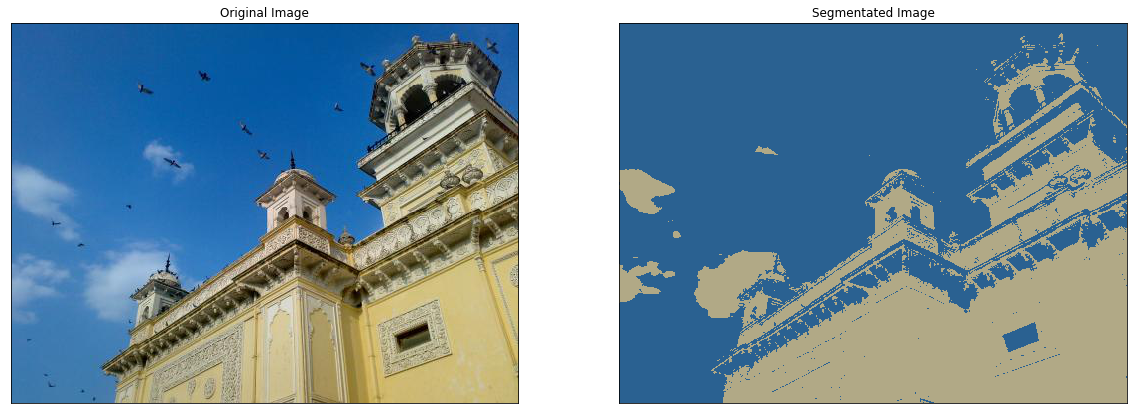

In [10]:
import numpy as np
import cv2

img = cv2.cv2.cvtColor(cv2.imread('home.jpg'), cv2.COLOR_BGR2RGB)
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
segmentation = center[label.flatten()]
segmentation = segmentation.reshape((img.shape))

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(segmentation)
plt.title("Segmentated Image"), plt.xticks([]), plt.yticks([])
plt.show()